# Import of needed packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import pandas as pd
import pydst
dst = pydst.Dst(lang='en')
import ipywidgets as widgets
%matplotlib inline

# Fetch Data
## The following section will fetch data using Statistics Denmark's API

## Educational Data

In [52]:
#Ultimately, we want to look at the share of people who have a bachelor's degree or higher across municipalities and time
#So we want the table HFUDD10
dst.get_data(table_id = 'HFUDD10')

#Now, we take a look at the variabels
hfudd_var = dst.get_variables(table_id='HFUDD10')
hfudd_var

#Next, look at the dictionary under values, to see the categories in order to specify what variables we need
udd = hfudd_var.loc[2,'values']
udd

#First, we create a list of the main categories i.e. education level higher or equal to bachelor
# Next we pick them from the HFUDD10 table and put into the dataframe hfudd10
hfudd_list = ['TOT','H60','H70','H80']
hfudd10 = dst.get_data(table_id = 'HFUDD10', variables={'BOPOMR':['*'], 'HFUDD':hfudd_list, 'TID':['*']})
hfudd10.tail()

#Drop unnecessary columns
hfudd10.drop(['ALDER','HERKOMST','KØN'], axis=1, inplace=True)
    
#Select all of the higher education categories sum them across each municipality and year.
group = hfudd10.loc[(hfudd10['HFUDD'] != 'Total')].copy() #Split
group1 = group.groupby(['BOPOMR', 'TID'])['INDHOLD'].sum() #Apply
group2 = pd.DataFrame(group1)
group2.rename(columns = {'INDHOLD':'HIGH_EDU'}, inplace=True) #Rename column

#Select the total in each municipality and year.
total = hfudd10.loc[(hfudd10['HFUDD'] == 'Total')].copy() #Split
total1 = total.groupby(['BOPOMR', 'TID'])['INDHOLD'].sum() #Apply
total2 = pd.DataFrame(total1)
total2.rename(columns = {'INDHOLD':'TOTAL'}, inplace=True) #Rename column

#Merge the data, reset index and get some proper variable names
merge = pd.merge(group2,total2,how='left',on=['BOPOMR','TID']) #Combine
merge['HIGH_EDU_SHARE'] = merge['HIGH_EDU'] / merge['TOTAL'] * 100 #Share of highly educated
merge.reset_index(inplace=True)
merge.rename(columns = {'BOPOMR':'MUNICIPALITY','TID':'YEAR'}, inplace=True) #Rename column
hfudd10 = merge

#Delete all rows that is not a municipality in the residence column
for val in ['Region', 'Province', 'All Denmark']: 
    I = hfudd10.MUNICIPALITY.str.contains(val)
    hfudd10 = hfudd10.loc[I == False]

hfudd10.head()

,MUNICIPALITY,YEAR,HIGH_EDU,TOTAL,HIGH_EDU_SHARE
0,Aabenraa,2006,1322,41865,3.157769
1,Aabenraa,2007,1367,41938,3.259574
2,Aabenraa,2008,1449,42097,3.442051
3,Aabenraa,2009,1498,42255,3.545143
4,Aabenraa,2010,1515,41920,3.614027


## Income Data

In [53]:
#Ultimately, we want to look at the household average income across municipality and time.
#Thus, we fetch the table INDKP106. 

#Dictionary of variables
variables = {'OMRÅDE':['*'], 'ENHED':['118'], 'KOEN':['MOK'], 'ALDER1':['00'], 'INDKINTB':['000'], 'TID':['*']}

#Call the API
indkp106 = dst.get_data(
    table_id = 'INDKP106',
    variables = variables)

#Drop redundant variables
indkp106.drop(['ENHED', 'KOEN', 'ALDER1', 'INDKINTB'], axis = 1, inplace = True)

#Rename columns
indkp106.rename(columns = {'OMRÅDE': 'MUNICIPALITY', 'ENHED': 'UNIT', 'KOEN': 'GENDER', 'INDKINTB': 'AVGINCOME', 'TID': 'YEAR'}, inplace = True)

for val in ['Region', 'Province', 'All Denmark']: 
    I = indkp106.MUNICIPALITY.str.contains(val)
    indkp106 = indkp106.loc[I == False]

indkp106.head()

,MUNICIPALITY,YEAR,INDHOLD
0,Høje-Taastrup,2013,205502
1,Struer,2013,196670
2,Ærø,2013,180695
3,Horsens,2013,204107
4,Aarhus,2013,207081


## Immigration Data (from the population data)

In [54]:
#Ultimately, we want to look at the share of immigrants across municipality and time.
variables = {'OMRÅDE':['*'],'HERKOMST':["*"],"TID":["*"]}
folk_api = dst.get_data(table_id = 'FOLK1C', variables=variables)

#We match the observation at 1st of january with the other datasets, thus selecting the first quarter (=Q1)
folk_q1 = folk_api[folk_api["TID"].str.contains("Q1")].copy()

#Convert to datetime format that python knows
folk_q1["TID"]=pd.to_datetime(folk_q1["TID"])

#Create year variable which matches the data in section 1.1 and 1.2
folk_q1["YEAR"] = folk_q1["TID"].dt.year

#Drop redundant variables
folk_q1 = folk_q1.drop(["TID","KØN","IELAND","ALDER"],axis=1)

#Select all of the immigrants across each municipality and year.
group_folk = folk_q1.loc[(folk_q1['HERKOMST'] == 'Immigrants')].copy() #Split
group1_folk = group_folk.groupby(['OMRÅDE', 'YEAR'])['INDHOLD'].sum() #Count
group2_folk = pd.DataFrame(group1_folk)
group2_folk.rename(columns = {'INDHOLD':'immigrants'}, inplace=True) #Rename column

#Select the total in each municipality and year.
total_folk = folk_q1.loc[(folk_q1['HERKOMST'] == 'Total')].copy() #Split
total1_folk = total_folk.groupby(['OMRÅDE', 'YEAR'])['INDHOLD'].sum() #Count
total2_folk = pd.DataFrame(total1_folk)
total2_folk.rename(columns = {'INDHOLD':'TOTAL'}, inplace=True) #Rename column

#Merge the data, reset index and get some proper variable names
folk1c = pd.merge(group2_folk,total2_folk,how='left',on=['OMRÅDE','YEAR'])
folk1c['Immigrants_share'] = folk1c['immigrants'] / folk1c['TOTAL'] * 100
folk1c.reset_index(inplace=True)
folk1c.rename(columns = {'OMRÅDE':'MUNICIPALITY','YEAR':'YEAR'}, inplace=True) #Rename column

#Delete all rows that is not a municipality in the residence column
for val in ['Region', 'Province', 'All Denmark']: 
    I = folk1c.MUNICIPALITY.str.contains(val)
    folk1c = folk1c.loc[I == False]

folk1c.head()

,MUNICIPALITY,YEAR,immigrants,TOTAL,Immigrants_share
0,Aabenraa,2008,5127,60189,8.518168
1,Aabenraa,2009,5306,60392,8.785932
2,Aabenraa,2010,5307,59978,8.848244
3,Aabenraa,2011,5376,59795,8.990718
4,Aabenraa,2012,5478,59600,9.191275


In [55]:
#Ultimately, we want the number of people recieving social benefits across municipality and time.
#Thus, we fetch KY038
#Dictionary of variables
variables = {'OMRÅDE':['*'], 'YDELSESTYPE':['10000'], 'HERKOMST': ['00'], 'HERKOMST1':['TOT'], 'TID':['*']} 

#Call the API
ky038 = dst.get_data(
    table_id = 'KY038',
    variables = variables)

#Drop redundant variables
ky038 = ky038.drop(['HERKOMST', 'HERKOMST1',"YDELSESTYPE"], axis = 1)

#Rename colums
ky038 = ky038.rename(columns = {'OMRÅDE': 'MUNICIPALITY','TID':'YEAR',"INDHOLD":"COUNT_KTH"})

#Delete all rows that is not a municipality in the residence column
for val in ['Region', 'Province', 'All Denmark']: 
    I = ky038.MUNICIPALITY.str.contains(val)
    ky038 = ky038.loc[I == False]

ky038.head()

,MUNICIPALITY,YEAR,COUNT_KTH
0,Helsingør,2008,1402
1,Hillerød,2008,667
2,Hørsholm,2008,164
3,Rudersdal,2008,399
4,Egedal,2008,231


# Merge
## The following section will merge the cleaned datasets

In [65]:
#Overview of dimensions
print(f'folk1c {folk1c.shape}')
print(f'hfudd10 {hfudd10.shape}')
print(f'indkp {indkp106.shape}')
print(f'ky038 {ky038.shape}')

#Find out what years we want to match when we merge
for data in [folk1c, hfudd10, indkp106, ky038]:
    count = data["YEAR"].value_counts()
    print(f'Years: {count}')

folk1c (1287, 5)
hfudd10 (1386, 5)
indkp (3136, 3)
ky038 (1188, 3)
Years: 2020    99
2019    99
2018    99
2017    99
2016    99
2015    99
2014    99
2013    99
2012    99
2011    99
2010    99
2009    99
2008    99
Name: YEAR, dtype: int64
Years: 2019    99
2018    99
2017    99
2016    99
2015    99
2014    99
2013    99
2012    99
2011    99
2010    99
2009    99
2008    99
2007    99
2006    99
Name: YEAR, dtype: int64
Years: 2017    98
2015    98
1990    98
1992    98
1994    98
1996    98
1998    98
2000    98
2002    98
2004    98
2006    98
2008    98
2010    98
2012    98
2014    98
2016    98
2018    98
1987    98
1989    98
1991    98
1993    98
1995    98
1997    98
1999    98
2001    98
2003    98
2005    98
2007    98
2009    98
2011    98
2013    98
1988    98
Name: YEAR, dtype: int64
Years: 2018    99
2017    99
2016    99
2015    99
2014    99
2013    99
2012    99
2011    99
2010    99
2009    99
2008    99
2007    99
Name: YEAR, dtype: int64


In [ ]:
# Immigration goes from 2008-2019
# Educational goes from 2006-2018
# Income goes from 1988-2018
# Social benefits goes from 2007-2017

#Thus, we want first outer join Immigration and Educational: 2006-2019
#Then, left join the others: 2006-2019

In [69]:
merge_df = pd.merge(folk1c, hfudd10, on=["MUNICIPALITY","YEAR"],how="outer")
merge_df2 = pd.merge(merge_df, indkp106, on=["MUNICIPALITY","YEAR"],how="left")
merge_df3 = pd.merge(merge_df2, ky038, on=["MUNICIPALITY","YEAR"],how="left" )
merge_df3.head()

,MUNICIPALITY,YEAR,immigrants,TOTAL_x,Immigrants_share,HIGH_EDU,TOTAL_y,HIGH_EDU_SHARE,INDHOLD,COUNT_KTH
0,Aabenraa,2008,5127.0,60189.0,8.518168,1449.0,42097.0,3.442051,166290.0,1018.0
1,Aabenraa,2009,5306.0,60392.0,8.785932,1498.0,42255.0,3.545143,167106.0,1213.0
2,Aabenraa,2010,5307.0,59978.0,8.848244,1515.0,41920.0,3.614027,181280.0,1351.0
3,Aabenraa,2011,5376.0,59795.0,8.990718,1571.0,41704.0,3.767025,184117.0,1312.0
4,Aabenraa,2012,5478.0,59600.0,9.191275,1614.0,41525.0,3.886815,188090.0,1339.0


In [70]:
#Final clean
merge_df3 = merge_df3.drop(["TOTAL_y"],axis=1)
merge_df3.columns=["Municipality", "Year","Immigrants","Population","Immigrants_share","High_EDU","High_EDU_share","Avg_income","Count_KTH"]
#Share of population on social benefits
merge_df3["Avg_KTH"]=merge_df3["Count_KTH"]/merge_df3["Population"]*100
merge_df3.head()

,Municipality,Year,Immigrants,Population,Immigrants_share,High_EDU,High_EDU_share,Avg_income,Count_KTH,Avg_KTH
0,Aabenraa,2008,5127.0,60189.0,8.518168,1449.0,3.442051,166290.0,1018.0,1.691339
1,Aabenraa,2009,5306.0,60392.0,8.785932,1498.0,3.545143,167106.0,1213.0,2.008544
2,Aabenraa,2010,5307.0,59978.0,8.848244,1515.0,3.614027,181280.0,1351.0,2.252493
3,Aabenraa,2011,5376.0,59795.0,8.990718,1571.0,3.767025,184117.0,1312.0,2.194163
4,Aabenraa,2012,5478.0,59600.0,9.191275,1614.0,3.886815,188090.0,1339.0,2.246644


# Data visualization and Analysis

## Education and average income

In [75]:
#First, define a function which plots the share of highly educated agianst average income. 
#Each dot represents a municipality.
#It is done within a function such that we can incorporate a slide.
def edu(year):
    df = merge_df3.loc[merge_df3["Year"]==year].copy()
    plt.figure(figsize=(10,10))
    plt.scatter(df["High_EDU_share"], df["Avg_income"],cmap='viridis',c=df["High_EDU_share"]) #Colour changes with the x-axis
    plt.xlabel("Share of individuals with higher education", fontsize=16)
    plt.ylabel("Average income", fontsize=16)

#Now we set the interactive slider to change the years.
#Thus, the relationship between education and average income can be seen in a preferable year.
widgets.interact(edu,year=(2008,2018))
n_widget = widgets.IntSlider(
                value=2,
                min=2008,
                max=2018)

interactive(children=(IntSlider(value=2013, description='year', max=2018, min=2008), Output()), _dom_classes=(…

* The data suggest a positive correlation between the share of highly educated people and the average income in each municipality in each year

## Share of immigrants and share of population on social benefits

In [81]:
#Agian, we define the function which creates the scatter plot
def immi(year):
    df = merge_df3.loc[merge_df3["Year"]==year].copy()
    plt.figure(figsize=(10,10))
    plt.scatter(df["Immigrants_share"], df["Avg_KTH"],cmap='viridis',c=df["Immigrants_share"]) #Colour changes with the x-axis
    plt.xlabel("Share of immigrants", fontsize=16)
    plt.ylabel("Share of individuals on public support", fontsize=16)

#Set up the widget with a slider for years
widgets.interact(immi,year=(2010,2018))
n_widget = widgets.IntSlider(
                value=2,
                min=2010,
                max=2018)

interactive(children=(IntSlider(value=2014, description='year', max=2018, min=2010), Output()), _dom_classes=(…

* The data show no clear correlation. One could argue there is a slight positive correlation. It does seem spurious, however.

## Devolopment of the demeaned share of immigrants

[]

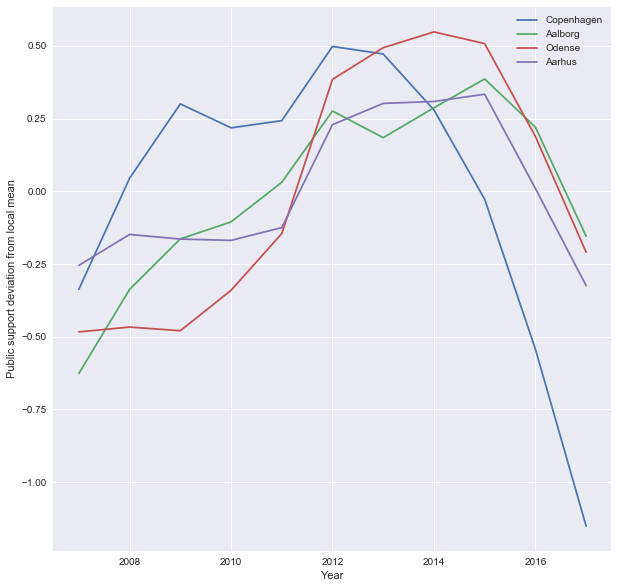

In [93]:
#We want to see how the share of people on social benefits 'kontanthjælp' has evolved in the four biggest municipalities. 
#By demeaning the share withing each municipality we get a relative measure.

#Data selection
mean = merge_df3.loc[merge_df3["Year"] != 2019].copy() #Social benefit data is not issued for 2019

#Apply-Split-Combine using the transform-method to achieve the measure described above
mean["KTH_demeaned"] = merge_df3.groupby(['Municipality'])['Avg_KTH'].transform(lambda x: x-x.mean())

#Create dataframes for each municipality
cph = mean.loc[mean["Municipality"]=="Copenhagen"]
aal = mean.loc[mean["Municipality"]=="Aalborg"]
od = mean.loc[mean["Municipality"]=="Odense"]
aar = mean.loc[mean["Municipality"]=="Aarhus"]

#Create a list of years that goes on the x-axis. This is done as a pandas series can't be input in the plot.
year = [2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]

#Now create the plot of demeaned share of people receving kontanthjælp
plt.figure(figsize=(10,10))
#Add each municipality to the plot
plt.plot(year,cph["KTH_demeaned"],label="Copenhagen")
plt.plot(year,aal["KTH_demeaned"],label="Aalborg")
plt.plot(year,od["KTH_demeaned"],label="Odense")
plt.plot(year,aar["KTH_demeaned"],label="Aarhus")
#Set labels
plt.ylabel("Public support deviation from local mean")
plt.xlabel("Year")
plt.legend()
plt.plot()

* We clearly see the 'kontanthjælpsreform' from mid 2013 decreasing the number of people receiving kontanthjælp. With the jobcenters in Copenhagen doing the best job relatively.